# Exploring Regulatory Genomic Regions and Causal Variants with gkm-SVM and its Interpretive Methods 
## CME 216 Course Project
### David Neese

###Introduction

This notebook illustrates the power of the gkm-SVM classification method and several methods designed to interpret its results. The gkm-SVM is trained on intron regions in microglia and excitatory neurons that have been marked out as peaks in ATAC-Seq data. From this it is able to predict whether any input DNA sequence will act as an enhancer or promoter in a given cell type. Furthermore, we can estimate the effect of variants in these regulatory regions using gkmExplain, which generates a position weight matrix (PWM) to explain the contribution of each position in a sequence to its classification as an enhancer or a non-regulatory region.

### Citations

The ls-gkm model used: https://github.com/Dongwon-Lee/lsgkm

The gkmExplain model used: https://github.com/kundajelab/gkmexplain

The sequence visualizer used: https://github.com/kundajelab/vizsequence

Additionally, code for this notebook was modified from the following demo notebooks for gkmExplain:
- https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_TALGATA.ipynb
- https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb


###Rough Outline of this Notebook

- Import and subset data
- Train the gkm-SVM models
    - train one model for each cell type/cluster
- Test the models
    - obtain precision, recall, ROC AUC
- Analyze example output
    - show gkmExplain output and relation to motifs
    - show effect of variants on classification
    - show limited applicability of models across cell types

##Training

For a note on files: most of them are taken care of by `!wget` commands, but there are a few I've had to upload from my local device:
- traindata.txt: data I saved after training cl1_gkmtrain.model.txt
- cl1_gkmtrain.model.txt: the trained cluster 1 model
- cl24_gkmtrain.model.txt: the trained cluster 24 model

The latter two can be obtained by running cells below; the traindata.txt file was simply scraped from the output of one of the training cells

In [1]:
#import training/testing data from two cell types or clusters linked with Alzheimer's

# Import cluster 1 - Excitatory Neurons
!wget -O train.final.pos.fasta https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster1/fold1/train/train.final.pos.fasta 
!wget -O train.final.neg.fasta https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster1/fold1/train/train.final.neg.fasta
!wget -O test.final.pos.fasta https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster1/fold1/test/test.final.pos.fasta 
!wget -O test.final.neg.fasta https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster1/fold1/test/test.final.neg.fasta

# Import cluster 24 - microglia
!wget -O train.final.pos2.fasta https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster24/fold0/train/train.final.pos.fasta
!wget -O train.final.neg2.fasta https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster24/fold0/train/train.final.neg.fasta
!wget -O test.final.pos2.fasta https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster24/fold0/test/test.final.pos.fasta
!wget -O test.final.neg2.fasta https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster24/fold0/test/test.final.neg.fasta 

--2023-03-24 02:33:34--  https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster1/fold1/train/train.final.pos.fasta
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60468890 (58M)
Saving to: ‘train.final.pos.fasta’

train.final.pos.fas 100%[===================>]  57.67M  45.2MB/s    in 1.3s    

2023-03-24 02:33:35 (45.2 MB/s) - ‘train.final.pos.fasta’ saved [60468890/60468890]

--2023-03-24 02:33:35--  https://mitra.stanford.edu/kundaje/soumyak/adpd_humbio51/svm_inputs/Cluster1/fold1/train/train.final.neg.fasta
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60468890 (58M)
Saving to: ‘train.final.neg.fasta’

train.final.neg.fas 100%[=================

In [2]:
# set up the gkm-SVM
!git clone https://github.com/Dongwon-Lee/lsgkm lsgkm
%cd lsgkm/src
!make
%cd ../..

Cloning into 'lsgkm'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 132 (delta 14), reused 22 (delta 8), pack-reused 99
Receiving objects: 100% (132/132), 277.60 KiB | 3.60 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmtrain_svr.c libsvm.o libsvm_gkm.o -o gkmtrain-svr -lm -lpthread
/content


In [3]:
# For a quick visualization of what the input sequences look like:
# Fasta format -> >header + DNA sequence
!head test.final.pos.fasta

>0
ATGCCAGGGAAATCCAACCGTGCTTCCCACGCTGGCATCGCTCTGATTATGACCAATCCTCTAATCTTATTCTCACAATTAGGGAGGAAGAAAAAAAAACAAACCCAAACCAAAAAAGAAGTTGGTAGGTGACTCTGTGAGACTACTGTTTTATAAAGGGAGCGTTTCCTTTTATAAAATTTAGCTGAGCAGATGCTAGGCAGCCCACAGGAGGCCACTATTCCCCTCAGCTGTACAGTTTGGGAAAATACCTACACACCCGGAGAACAGAGAGCTTGGTGTGTGTTGAGTTCGCTCCTGTTCATCAGCAGCCCTTTCCCCGCCTCTGGCCACCAGGGGGACCTGCAACCAAGTATGTGTTCTTTCAGGCGAGCGGGAACGCGTCTGCATAAATCTAGTCCAATCCAGGGCCCCGTAGCAAGGCGCCAAAGCTGGGGGAAGCGCATTTCTGTTCTCTCGCGAGCACGACGCGGTGCCTCCCAGTCCTCCTCCGGCCCTCCCTCTCCGCCCTCCCGGCCCGCGAGCGCTCGGGCCCCTTCCAGTGGCTCGCGGCAGGTGGCGCTGTCTGCGGCGTCGCAGCGGCCCGGGCTGCAGCAGAGACGATCTCCCGGCGGGCTGTGCGGCCCGGCTCTCCGGCGGCAGCGAGTGCCACGTCCCAAGTGCTACGCGGAGGATTAGAGCAGGCGGTGCGCTGGGGGCGGGAGCAGCGCGGAGCCCGGCTCGGCCACACCGATCGCCCGCCGCCATGGGCTCCTCGCAAAGCGTCGAGATCCCGGGCGGGGGCACCGAGGGCTACCACGTTCTGCGGGTAAGGGCTCCGACGGCGGCCGGGGAGCTGCGGGCTGGAGGCGGGGCCGGCCGCGGGGAGGCGGAGGCCCCCATGGGCTCCTTCACGGGGCAGCCAGGCCCGATCCCGCGAAGGAGCGGCGGTCGCGGGCGCTGCCTTGGTCGAGGCTGGTTCCGGAGGCCGCTCGCATCCCACCTCCGCGGAGCGCCC

In [4]:
# Subset all the training data to the first 10000 examples - otherwise training takes far too long

# Cluster 1 - Excitatory Neurons
!head -20000 train.final.neg.fasta > train.final.neg1.fasta
!head -20000 train.final.pos.fasta > train.final.pos1.fasta

# Cluster 24 - Microglia
!head -20000 train.final.neg2.fasta > train.final.neg24.fasta
!head -20000 train.final.pos2.fasta > train.final.pos24.fasta

Now we train both models. To save ourselves 14 hours, I've just uploaded previously trained models and will be working with them.

A brief word on the gkmtrain command and its flags

Governing the construction of gapped kmers:
- word length (lmer size): default 11
- size of k in kmer (word length): default 7
- allowed number of mismatches: default 3

More broadly governing model performance and convergence
- kernel type: standard (non center weighted) linear gkm kernel
- regularization: none
- precision (epsilon): default 0.001
- shrinking heuristics: applied for the cl1_gkmtrain, but not cl2_gkmtrain (doesn't improve speed at all)

In [ ]:
# Train on Excitatory Neurons (Cluster 1)
! ./lsgkm/src/gkmtrain -T 4 -t 2 /content/train.final.pos1.fasta /content/train.final.neg1.fasta cl1_gkmtrain

INFO 2023-03-23 04:57:02: Arguments:
INFO 2023-03-23 04:57:02:   posfile = /content/train.final.pos2.fasta
INFO 2023-03-23 04:57:02:   negfile = /content/train.final.neg2.fasta
INFO 2023-03-23 04:57:02:   outprefix = cl1_gkmtrain
INFO 2023-03-23 04:57:02: Parameters:
INFO 2023-03-23 04:57:02:   kernel-type = 2
INFO 2023-03-23 04:57:02:   L = 11
INFO 2023-03-23 04:57:02:   k = 7
INFO 2023-03-23 04:57:02:   d = 3
INFO 2023-03-23 04:57:02:   C = 1
INFO 2023-03-23 04:57:02:   eps = 0.001
INFO 2023-03-23 04:57:02:   shrinking = yes
INFO 2023-03-23 04:57:02:   reverse-complement feature = yes
INFO 2023-03-23 04:57:02: reading 10000 sequences from /content/train.final.pos2.fasta
INFO 2023-03-23 04:57:02: reading... 0
INFO 2023-03-23 04:57:04: reading... 1000
INFO 2023-03-23 04:57:06: reading... 2000
INFO 2023-03-23 04:57:08: reading... 3000
INFO 2023-03-23 04:57:10: reading... 4000
INFO 2023-03-23 04:57:13: reading... 5000
INFO 2023-03-23 04:57:15: reading... 6000
INFO 2023-03-23 04:57:17: re

In [ ]:
# Train on microglia cells (cluster 24)
! ./lsgkm/src/gkmtrain -T 4 -t 2 /content/train.final.pos24.fasta /content/train.final.neg24.fasta cl24_gkmtrain

Over 34000 iterations and a rather agonizing 14 hours later, we have our trained models! As we can see from the graph below (using the data from only cl1's training), training followed an s-curve with a long tail - we probably could've benefited from early stoppage

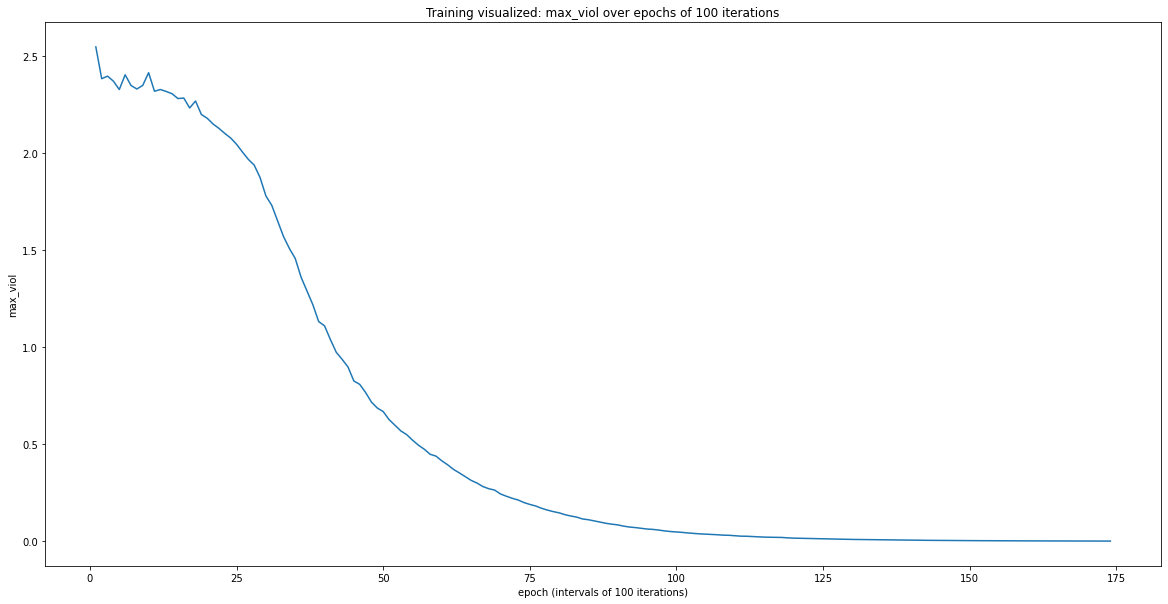

In [ ]:
# Here we visualize the training by plotting max_viol (a measure of the gradient that must get below eps=0.001) against
# training epoch (measured in 100s of iterations)
from matplotlib import pyplot as plt
import numpy as np

max_viols = [float(x) for x in open("/content/traindata.txt")] #"\t"?
x = np.arange(1, len(max_viols)+1)

plt.figure(figsize=(20,10))
plt.plot(x, max_viols)
plt.title("Training visualized: max_viol over epochs of 100 iterations")
plt.xlabel("epoch (intervals of 100 iterations)")
plt.ylabel("max_viol")
plt.show()

## Testing 

In [5]:
# Subset all the training data to the first 10000 examples - otherwise the training takes far too long

# Cluster 1 - Excitatory Neurons
!head -2000 test.final.neg.fasta > test.final.neg1.fasta
!head -2000 test.final.pos.fasta > test.final.pos1.fasta

# Cluster 24 - Microglia
!head -2000 test.final.neg2.fasta > test.final.neg24.fasta
!head -2000 test.final.pos2.fasta > test.final.pos24.fasta

In [50]:
#run gkmpredict - cluster 1
#NOTE: you will need to change the filepath for the gkm model if you train in the cells above
! ./lsgkm/src/gkmpredict /content/test.final.pos1.fasta /content/cl1_gkmtrain.model.txt cl1_gkmpredict.pos.txt
! ./lsgkm/src/gkmpredict /content/test.final.neg1.fasta /content/cl1_gkmtrain.model.txt cl1_gkmpredict.neg.txt

INFO 2023-03-24 03:58:12: load model /content/cl1_gkmtrain.model.txt
INFO 2023-03-24 03:58:12: reading 11810 SVs
INFO 2023-03-24 03:58:59: write prediction result to cl1_gkmpredict.pos.txt
INFO 2023-03-24 03:59:25: 100 scored
INFO 2023-03-24 03:59:52: 200 scored
INFO 2023-03-24 04:00:19: 300 scored
INFO 2023-03-24 04:00:46: 400 scored
INFO 2023-03-24 04:01:14: 500 scored
INFO 2023-03-24 04:01:43: 600 scored
INFO 2023-03-24 04:02:10: 700 scored
INFO 2023-03-24 04:02:36: 800 scored
INFO 2023-03-24 04:03:03: 900 scored
INFO 2023-03-24 04:03:29: 1000 scored
INFO 2023-03-24 04:03:30: load model /content/cl1_gkmtrain.model.txt
INFO 2023-03-24 04:03:30: reading 11810 SVs
INFO 2023-03-24 04:04:18: write prediction result to cl1_gkmpredict.neg.txt
INFO 2023-03-24 04:04:46: 100 scored
INFO 2023-03-24 04:05:12: 200 scored
INFO 2023-03-24 04:05:39: 300 scored
INFO 2023-03-24 04:06:05: 400 scored
INFO 2023-03-24 04:06:33: 500 scored
INFO 2023-03-24 04:06:59: 600 scored
INFO 2023-03-24 04:07:25: 700

In [10]:
# Print out some metrics to evaluate the model - cluster 1

# import sklearn.metrics as skm
from sklearn.metrics import roc_auc_score                                                                                                                    
pos_preds = [float(x.rstrip().split("\t")[1])                                   
             for x in open("cl1_gkmpredict.pos.txt")]                         
neg_preds = [float(x.rstrip().split("\t")[1])                                   
             for x in open("cl1_gkmpredict.neg.txt")]

count_fp = 0
count_fn = 0
for pred in pos_preds:
    if pred < 0: count_fn += 1
for pred in neg_preds:
    if pred > 0: count_fp += 1
# print(f"true positives: {1 - (count_fn/len(pos_preds))}")
# print(f"false positives: {count_fp/len(neg_preds)}")
# print(f"true negatives: {1 - (count_fp/len(neg_preds))}")
# print(f"false negatives: {count_fn/len(pos_preds)}")

print("Cluster 1 model metrics - Excitatory Neurons")
# Precision: true positives / (true positives + true negatives)
print(f"Precision: {(len(pos_preds) - count_fn - count_fp) / (len(pos_preds) - count_fn)}")
# Recall: true positives / (true positives + false negatives)
print(f"Recall: {(len(pos_preds) - count_fn - count_fp) / len(pos_preds)}")                     
roc_auc = roc_auc_score(y_true=[1 for x in pos_preds]+[0 for x in neg_preds],       
                        y_score = pos_preds+neg_preds)
print(f"ROC AUC score: {roc_auc}")

Cluster 1 model metrics - Excitatory Neurons
Precision: 0.8772678762006404
Recall: 0.822
ROC AUC score: 0.9672289999999999


In [11]:
#run gkmpredict - cluster 24
! ./lsgkm/src/gkmpredict /content/test.final.pos24.fasta /content/cl24_gkmtrain.model.txt cl24_gkmpredict.pos.txt
! ./lsgkm/src/gkmpredict /content/test.final.neg24.fasta /content/cl24_gkmtrain.model.txt cl24_gkmpredict.neg.txt

INFO 2023-03-24 02:50:50: load model /content/cl24_gkmtrain.model.txt
INFO 2023-03-24 02:50:50: reading 12135 SVs
WARN 2023-03-24 02:51:11: 'Y' at (null)(642) is not a valid nucleotide. Only ACGT are allowed
INFO 2023-03-24 02:51:38: write prediction result to cl24_gkmpredict.pos.txt
INFO 2023-03-24 02:52:06: 100 scored
INFO 2023-03-24 02:52:33: 200 scored
INFO 2023-03-24 02:53:00: 300 scored
INFO 2023-03-24 02:53:27: 400 scored
INFO 2023-03-24 02:53:55: 500 scored
INFO 2023-03-24 02:54:22: 600 scored
INFO 2023-03-24 02:54:52: 700 scored
INFO 2023-03-24 02:55:24: 800 scored
INFO 2023-03-24 02:55:52: 900 scored
INFO 2023-03-24 02:56:26: 1000 scored
INFO 2023-03-24 02:56:26: load model /content/cl24_gkmtrain.model.txt
INFO 2023-03-24 02:56:26: reading 12135 SVs
WARN 2023-03-24 02:56:49: 'Y' at (null)(642) is not a valid nucleotide. Only ACGT are allowed
INFO 2023-03-24 02:57:15: write prediction result to cl24_gkmpredict.neg.txt
INFO 2023-03-24 02:57:44: 100 scored
INFO 2023-03-24 02:58:

In [13]:
# Print out some metrics to evaluate the model - cluster 24

# import sklearn.metrics as skm
from sklearn.metrics import roc_auc_score                                                                                                                    
pos_preds = [float(x.rstrip().split("\t")[1])                                   
             for x in open("cl24_gkmpredict.pos.txt")]                         
neg_preds = [float(x.rstrip().split("\t")[1])                                   
             for x in open("cl24_gkmpredict.neg.txt")]

count_fp = 0
count_fn = 0
for pred in pos_preds:
    if pred < 0: count_fn += 1
for pred in neg_preds:
    if pred > 0: count_fp += 1
# print(f"true positives: {1 - (count_fn/len(pos_preds))}")
# print(f"false positives: {count_fp/len(neg_preds)}")
# print(f"true negatives: {1 - (count_fp/len(neg_preds))}")
# print(f"false negatives: {count_fn/len(pos_preds)}")

print("Cluster 24 model metrics - Microglia")
# Precision: true positives / (true positives + true negatives)
print(f"Precision: {(len(pos_preds) - count_fn - count_fp) / (len(pos_preds) - count_fn)}")
# Recall: true positives / (true positives + false negatives)
print(f"Recall: {(len(pos_preds) - count_fn - count_fp) / len(pos_preds)}")                     
roc_auc = roc_auc_score(y_true=[1 for x in pos_preds]+[0 for x in neg_preds],       
                        y_score = pos_preds+neg_preds)
print(f"ROC AUC score: {roc_auc}")

Cluster 24 model metrics - Microglia
Precision: 0.8827667057444314
Recall: 0.753
ROC AUC score: 0.9477949999999999


Now we try a little experiment - we evaluate the model trained on Microglia data on the Excitatory Neuron test data. As we can see below, the results are definitely worse, but not actually that much worse. This is probably because there is some similarity in these cell types - both are, after all, brain cells. I would be curious to train several models on different subsets of the Excitatory Neuron data to see if the error between these models was around the same as the error of the Microglia model on the Excitatory Neuron test data.

In [51]:
#run gkmpredict - cluster 1 model on cluster 24 data
! ./lsgkm/src/gkmpredict /content/test.final.pos24.fasta /content/cl1_gkmtrain.model.txt cl124_gkmpredict.pos.txt
! ./lsgkm/src/gkmpredict /content/test.final.neg24.fasta /content/cl1_gkmtrain.model.txt cl124_gkmpredict.neg.txt

INFO 2023-03-24 04:08:45: load model /content/cl1_gkmtrain.model.txt
INFO 2023-03-24 04:08:45: reading 11810 SVs
INFO 2023-03-24 04:09:30: write prediction result to cl124_gkmpredict.pos.txt
INFO 2023-03-24 04:09:57: 100 scored
INFO 2023-03-24 04:10:23: 200 scored
INFO 2023-03-24 04:10:50: 300 scored
INFO 2023-03-24 04:11:16: 400 scored
INFO 2023-03-24 04:11:43: 500 scored
INFO 2023-03-24 04:12:09: 600 scored
INFO 2023-03-24 04:12:37: 700 scored
INFO 2023-03-24 04:13:06: 800 scored
INFO 2023-03-24 04:13:36: 900 scored
INFO 2023-03-24 04:14:06: 1000 scored
INFO 2023-03-24 04:14:06: load model /content/cl1_gkmtrain.model.txt
INFO 2023-03-24 04:14:06: reading 11810 SVs
INFO 2023-03-24 04:14:58: write prediction result to cl124_gkmpredict.neg.txt
INFO 2023-03-24 04:15:27: 100 scored
INFO 2023-03-24 04:15:57: 200 scored
INFO 2023-03-24 04:16:25: 300 scored
INFO 2023-03-24 04:16:52: 400 scored
INFO 2023-03-24 04:17:19: 500 scored
INFO 2023-03-24 04:17:47: 600 scored
INFO 2023-03-24 04:18:13:

In [52]:
# Print out some metrics to evaluate the cross-eval

# import sklearn.metrics as skm
from sklearn.metrics import roc_auc_score                                                                                                                    
pos_preds = [float(x.rstrip().split("\t")[1])                                   
             for x in open("cl124_gkmpredict.pos.txt")]                         
neg_preds = [float(x.rstrip().split("\t")[1])                                   
             for x in open("cl124_gkmpredict.neg.txt")]

count_fp = 0
count_fn = 0
for pred in pos_preds:
    if pred < 0: count_fn += 1
for pred in neg_preds:
    if pred > 0: count_fp += 1
# print(f"true positives: {1 - (count_fn/len(pos_preds))}")
# print(f"false positives: {count_fp/len(neg_preds)}")
# print(f"true negatives: {1 - (count_fp/len(neg_preds))}")
# print(f"false negatives: {count_fn/len(pos_preds)}")

print("Cluster 1 model on Cluster 24 testing data")
# Precision: true positives / (true positives + true negatives)
print(f"Precision: {(len(pos_preds) - count_fn - count_fp) / (len(pos_preds) - count_fn)}")
# Recall: true positives / (true positives + false negatives)
print(f"Recall: {(len(pos_preds) - count_fn - count_fp) / len(pos_preds)}")                     
roc_auc = roc_auc_score(y_true=[1 for x in pos_preds]+[0 for x in neg_preds],       
                        y_score = pos_preds+neg_preds)
print(f"ROC AUC score: {roc_auc}")

Cluster 1 model on Cluster 24 testing data
Precision: 0.8677884615384616
Recall: 0.722
ROC AUC score: 0.9230070000000001


## Analysis

But now what if we'd like to visualize our output? We can pick a few sequences and run them through gkmExplain and a visualizer, to see the reverse-engineered inferred relative contributions of each position to the final classification. I'll describe more what the graphs mean once we've run them - for now, let's just take three of our positive testing points, add some random variants to them, and see how they fare in classification and gkmExplain.

In [56]:
#pick out a small sample of enhancer regions and run some experiments on them

import random

#pick out the first three training examples to explore more
with open('test.final.pos1.fasta','r') as file:
    data = file.readlines()[:6]

#creates list with essentially 9 genes, 3 original sequences with 2 copies each
expanded = []
for i in range(3):
    for j in range(3):
        expanded.append(data[2*i])
        expanded.append(data[2*i+1])

pos = [0]*9
mut = ['']*9
#insert one random mutation for each of the first three training examples
for i in [3,5,9,11,15,17]:
    flag = False
    while flag == False:
        p = random.randint(1,len(expanded[i])-2)
        b = random.choice(['A','C','T','G'])
        if expanded[i][p] != b:
            flag = True
            expanded[i] = expanded[i][:p] + b + expanded[i][p+1:]
            pos[(i-1)//2] = p
            mut[(i-1)//2] = b

with open('variants.fasta','w') as file:
    file.writelines( expanded )


print(f"Where the mutations are: {pos}")
print(f"What the mutations are: {mut}")

Where the mutations are: [0, 988, 68, 0, 461, 828, 0, 153, 571]
What the mutations are: ['', 'T', 'C', '', 'T', 'A', '', 'G', 'T']


We now import the gkmExplain module

In [38]:
#import gkmExplain (there is some redundancy here - we technically could've only cloned this repo, since it also contains the material for training and testing)
! git clone https://github.com/kundajelab/lsgkm gkme
%cd gkme/src
!make
%cd ../..

Cloning into 'gkme'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 382 (delta 34), reused 32 (delta 15), pack-reused 323
Receiving objects: 100% (382/382), 585.86 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (247/247), done.
/content/gkme/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmexplain.c libsvm.o libsvm_gkm.o -o gkmexplain -lm -lpthread
/content


In [35]:
#just a check: how have the variants changed the scores?
#remember, lines 1/4/7 are the originals (the first line with each number)
! /content/lsgkm/src/gkmpredict variants.fasta /content/cl1_gkmtrain.model.txt predict_variants.txt
!cat predict_variants.txt

INFO 2023-03-24 03:31:46: load model /content/cl1_gkmtrain.model.txt
INFO 2023-03-24 03:31:46: reading 11810 SVs
INFO 2023-03-24 03:32:31: write prediction result to predict_variants.txt
INFO 2023-03-24 03:32:34: 9 scored
0	1.79038
0	1.80983
0	1.75929
1	0.892653
1	0.908562
1	0.948379
2	1.69037
2	1.71338
2	1.62247


So there is some minor change (some variants drove the score a bit up, some down), but most within $\pm 3\%$ or so

In [42]:
#another check: how cross applicable are the models?
! /content/lsgkm/src/gkmpredict variants.fasta /content/cl24_gkmtrain.model.txt predict_variants24.txt
!cat predict_variants24.txt

INFO 2023-03-24 03:41:35: load model /content/cl24_gkmtrain.model.txt
INFO 2023-03-24 03:41:35: reading 12135 SVs
WARN 2023-03-24 03:41:56: 'Y' at (null)(642) is not a valid nucleotide. Only ACGT are allowed
INFO 2023-03-24 03:42:21: write prediction result to predict_variants24.txt
INFO 2023-03-24 03:42:24: 9 scored
0	1.69085
0	1.66375
0	1.63397
1	1.28936
1	1.30443
1	1.26581
2	1.81156
2	1.83208
2	1.75526


Another check on training with the 'wrong' model - again the base values for the reference sequences are slightly altered, but the change with variants is still small

We now proceed to run gkmExplain on our examples, ultimately seeking to create a position weight matrix graph that visualizes the predicted motifs in the sequence:

In [53]:
# must get rid of an extra line in the cl1_gkmtrain.model.txt
! sed -i '6d' cl1_gkmtrain.model.txt
! /content/gkme/src/gkmexplain variants.fasta /content/cl1_gkmtrain.model.txt explanation_positives.txt

INFO 2023-03-24 04:22:43: Number of threads is set to 1
INFO 2023-03-24 04:22:43: load model /content/cl1_gkmtrain.model.txt
INFO 2023-03-24 04:22:47: reading... 1000/11810
INFO 2023-03-24 04:22:52: reading... 2000/11810
INFO 2023-03-24 04:22:55: reading... 3000/11810
INFO 2023-03-24 04:22:59: reading... 4000/11810
INFO 2023-03-24 04:23:04: reading... 5000/11810
INFO 2023-03-24 04:23:08: reading... 6000/11810
INFO 2023-03-24 04:23:12: reading... 7000/11810
INFO 2023-03-24 04:23:17: reading... 8000/11810
INFO 2023-03-24 04:23:21: reading... 9000/11810
INFO 2023-03-24 04:23:25: reading... 10000/11810
INFO 2023-03-24 04:23:31: reading... 11000/11810
INFO 2023-03-24 04:23:34: write prediction result to explanation_positives.txt
INFO 2023-03-24 04:26:25: 9 scored


For time saving reasons we weight the data by importance score, rather than by normalized hypothetical importance score - from here we simply plot it out for each of our sequences

In [54]:
from matplotlib import pyplot as plt
plt.style.use('default')
import numpy as np

# scrape importance scores from gkmExplain output
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("explanation_positives.txt")
]

In [ ]:
!pip install vizsequence
import vizsequence
from vizsequence import viz_sequence

Positive Sample 0: Reference


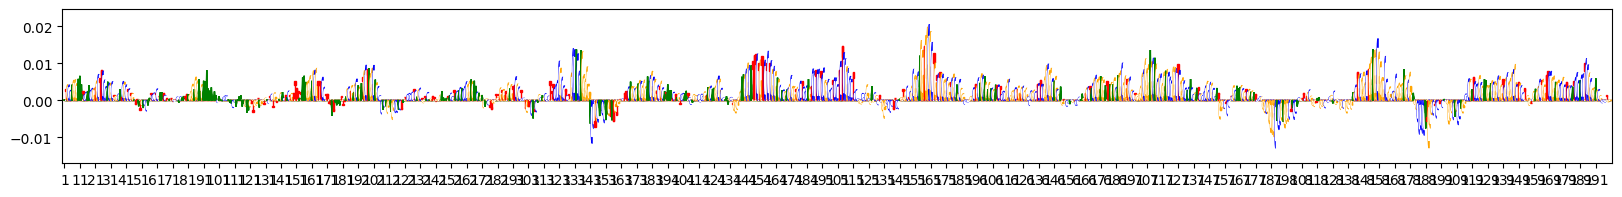

Positive Sample 0: T swapped in at position 988


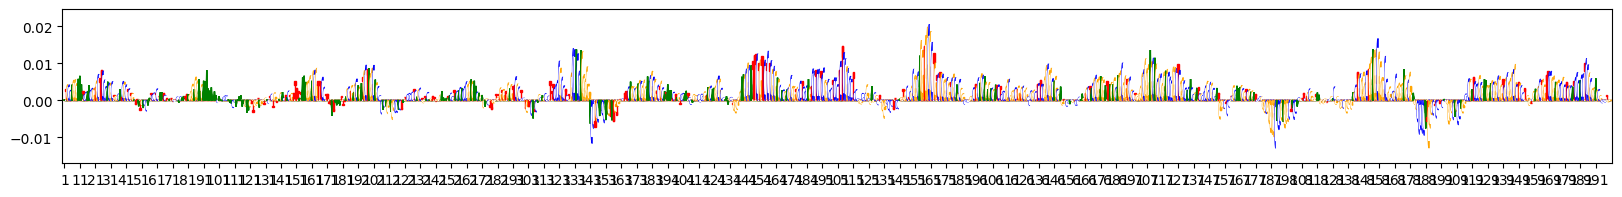

Positive Sample 0: C swapped in at position 68


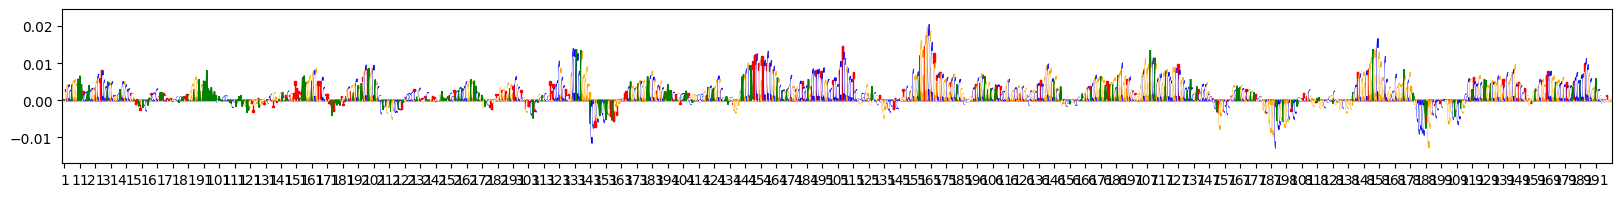

Positive Sample 1: Reference


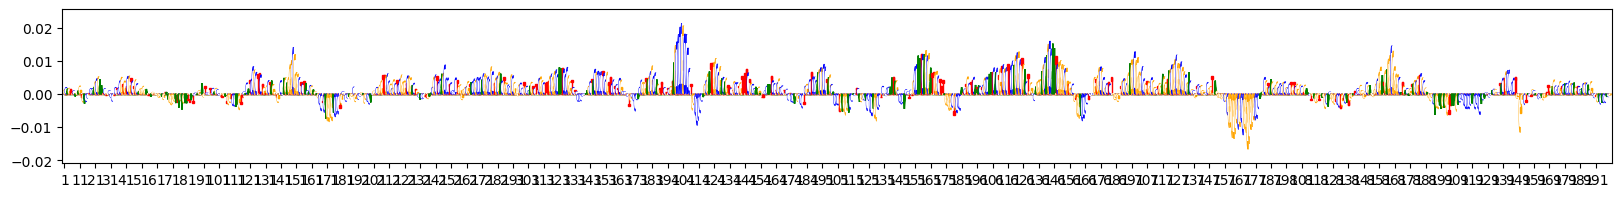

Positive Sample 1: T swapped in at position 461


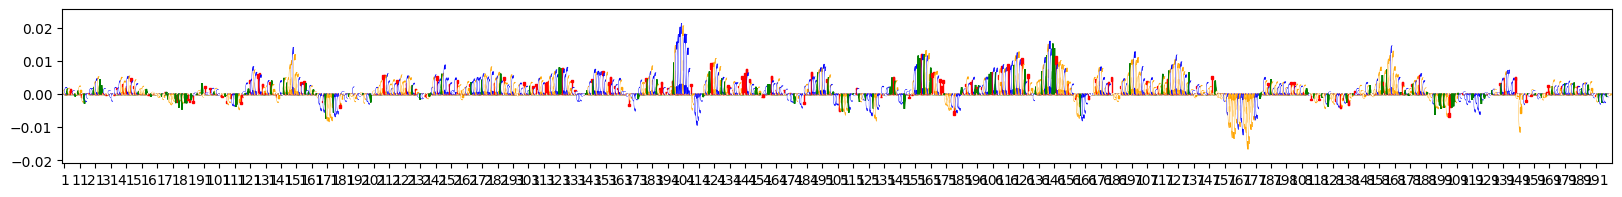

Positive Sample 1: A swapped in at position 828


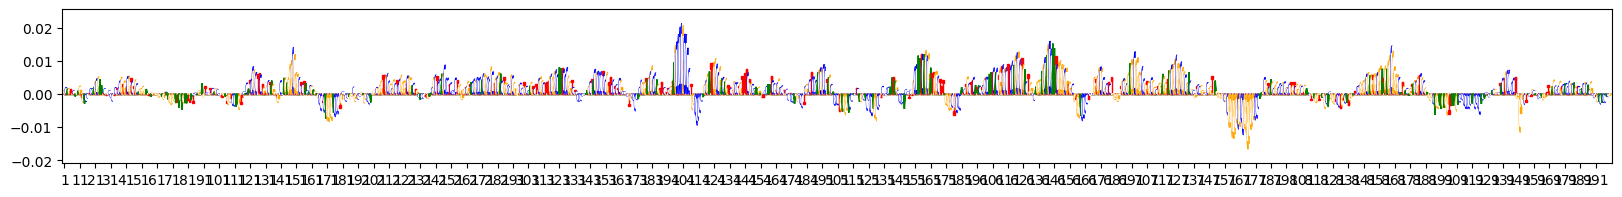

Positive Sample 2: Reference


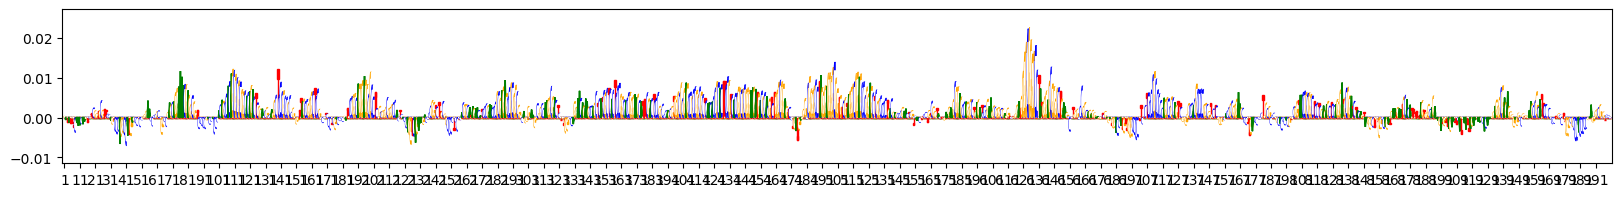

Positive Sample 2: G swapped in at position 153


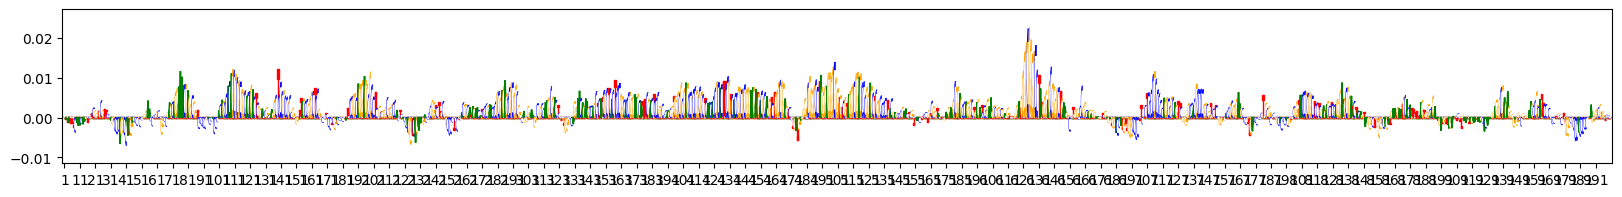

Positive Sample 2: T swapped in at position 571


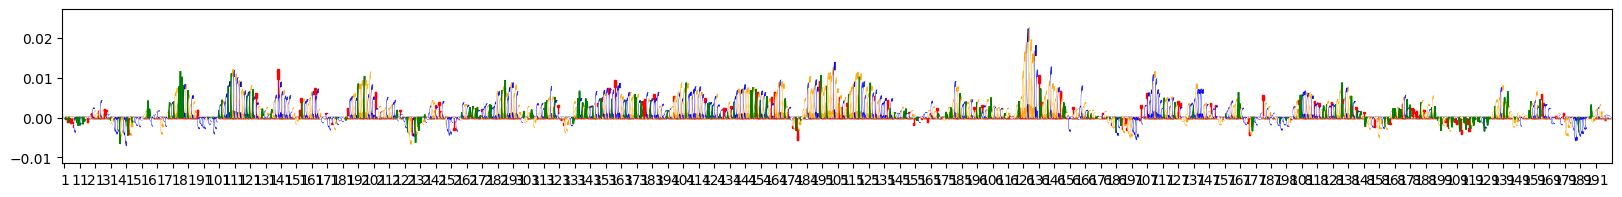

In [59]:
for i in range(9):
    if i % 3 == 0:
        print(f"Positive Sample {i//3}: Reference")
    else:
        print(f"Positive Sample {i//3}: {mut[i]} swapped in at position {pos[i]}")
    viz_sequence.plot_weights(impscores[i], subticks_frequency=10)

So what exactly do these graphs show us?

As mentioned before, gkmExplain takes the kernel of the gkm-SVM and reverse engineers it to find the contribution of each base at each position to the final classification. This graph is a visual depiction of that, with relative contribution of A, C, T, and G at each position represented by their letters stacked on top of each other. 

For example, the fact that there's an A instead of a T at position 259 of some sequence might be responsible for a lot of why it got classified as an enhancer region (if it were a T, perhaps, it wouldn't have added that much to the sequence's score). The graph would show this by plotting a large A on top of a small T (let's say C and G are also negligible), signifying that an A at position 259 is a great predictor of a region's regulatory function, whereas a T at that same position is not. 

Unfortunately these graphs (and the variants I chose) drive home the non-triviality of the task of identifying causal variants. Despite what one might initially assume, just any variation at any point in a regulatory region won't impede its function. Many variants just don't make much of an impact, as we can see in the graphs above - one can hardly tell that there's any variation in the graphs of each sample. 

If we wanted to refine our analysis, we'd select a few known causal variant SNPs (from GWAS, for example) and plot them against their reference sequence over a much more zoomed in region (perhaps 40-60 base pairs). This would give us a much clearer idea of what exactly a real disruption of enhancer function looks like - large peaks would fall. Additionally, it would give us a jumping off point for motif analysis, another thing we can get from gkmExplain - the TF motif "grammar" of each cell type we train on.

However, we should note that we might not even expect a causal variant to flip a region's classifier score from positive to negative (i.e. entirely destroy any resemblance to an enhancer region) - any enhancer region this large has many enhancers that bind to many TF's, and knocking out one might not destroy the function and binding of all the others.

So overall, we find gkm-SVM and its accompanying explanatory tools powerful, but not providing all the answers to our problems of interest. Careful research and application is still needed to get the most from them.

## Unfinished Extensions

Some unfinished extensions of the project I didn't quite have time to complete - my next idea was to do the above; that is, find a few SNPs confirmed on GWAS to be causally linked to Alzheimer's, and plot their PWMs / importance scores over a much smaller range. The big problem I was running into here was that the classifier seemed much less reliable at small scale - I couldn't just select a region $\pm 20$ around the mutation, as this would just always get me negative results (the sample is too small, it can't look like that much of an enhancer). I'd need to find the introns each SNP was located in, predict the regulatory status of those entire introns, then clip the output down to size around the motif of interest. Something to expand on later...

In [2]:
#seems a bit excessive, but important - download the human genome so we can convert bed files of variants (genomic coordinates) to corresponding DNA sequences
!wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip hg38.fa.gz
!apt-get install bedtools

--2023-03-23 21:45:58--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘hg38.fa.gz’

hg38.fa.gz          100%[===================>] 938.09M   101MB/s    in 9.4s    

2023-03-23 21:46:07 (100 MB/s) - ‘hg38.fa.gz’ saved [983659424/983659424]



In [35]:
#todo here: insert instead of train positives the bed/fasta files for the variants (4 - reference, variant 1, variant 2, random variant)
# if doesn't work - just take a few strongly positive samples from the test code and change them a bit - see what happens?
#(1) make bed file of regions?
# let's find a variant with strong effect size in Cluster 1, not in Cluster 24
# rs7900536, line 9655
# chr10, pos 80493945 C>A
# file1 = open('variants.bed', 'w')
# file1.write("chr10\t80493925\t80493965\t1\t+\n") #reference
# file1.write("chr10\t80493925\t80493965\t1\t+\n") #causal variant
# file1.write("chr10\t80493925\t80493965\t1\t+\n") #random variant
# file1.close()
file1 = open('variants.bed', 'w')
file1.write("chr1\t161185562\t161185642\t1\t+\n") #reference
file1.write("chr1\t161185562\t161185642\t1\t+\n") #causal variant
file1.write("chr1\t161185562\t161185642\t1\t+\n") #random variant
file1.write("chr1\t161185592\t161185612\t1\t+\n") #reference
file1.write("chr1\t161185592\t161185612\t1\t+\n") #causal variant
file1.write("chr1\t161185592\t161185612\t1\t+\n") #random variant
file1.close()

#(2) convert to fasta file
!bedtools getfasta -fi /content/hg38.fa -bed variants.bed -fo variants.fa.out

#(3) edit fasta file to sub in variants where we want
with open('variants.fa.out','r') as file:
    data = file.readlines()
# data[3] = data[3][:29] + 'A' + data[3][20:] #variant
# data[5] = data[5][:26] + 'T' + data[5][27:] #random variant
data[3] = data[3][:39] + 'A' + data[3][40:] #variant
data[5] = data[5][:26] + 'T' + data[5][27:] #random variant
data[9] = data[9][:9] + 'A' + data[9][10:] #variant
data[11] = data[11][:14] + 'C' + data[11][15:] #random variant
for i in range(len(data)):
    if i % 2 == 1: data[i] = data[i].upper()
with open('variants.fa.out', 'w') as file:
    file.writelines( data )

#(4) print new fasta file
!cat variants.fa.out

#(5) Other candidates
# rs80346216 (-22)
# rs3755519 (+)
# rs413778 (-)
# rs4575098, G>A, 161185602
# rs62054825 (+) and rs62054825 (-) -> 17, 45852666/7, (-)C->T / (+)A->G
# 

>chr1:161185562-161185642
ACTCAATTGGTTCAGAAACATCCTCTCAGCCAATAAAATGTTAATACATTGAAATCCACTTTCTTCTCCCTTCCTCCCCC
>chr1:161185562-161185642
ACTCAATTGGTTCAGAAACATCCTCTCAGCCAATAAAATATTAATACATTGAAATCCACTTTCTTCTCCCTTCCTCCCCC
>chr1:161185562-161185642
ACTCAATTGGTTCAGAAACATCCTCTTAGCCAATAAAATGTTAATACATTGAAATCCACTTTCTTCTCCCTTCCTCCCCC
>chr1:161185592-161185612
CAATAAAATGTTAATACATT
>chr1:161185592-161185612
CAATAAAATATTAATACATT
>chr1:161185592-161185612
CAATAAAATGTTAACACATT


In [ ]:
#Training the model on another cell type - results don't mix
#Try a different kernel?